In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import asyncio
import urllib.request

#Check if GPU is fried yet
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
data = np.load('flatland_train.npz')
X = data['X']
y = data['y']
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X.reshape(X.shape[0], 50, 50, 1) / 255

In [3]:
X.shape

(10000, 50, 50, 1)

In [4]:
Counter(y)

Counter({2.0: 1868, 4.0: 1761, 3.0: 2137, 1.0: 2853, 0.0: 1381})

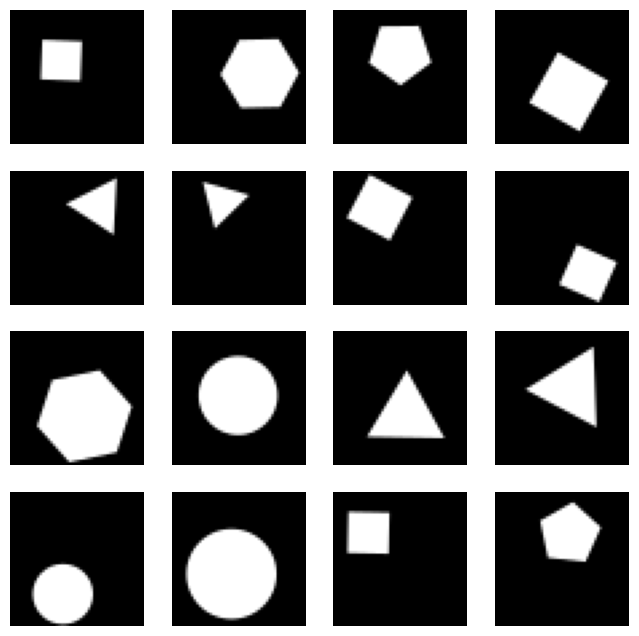

In [5]:
#Original data visualisation

data_generator = ImageDataGenerator()
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

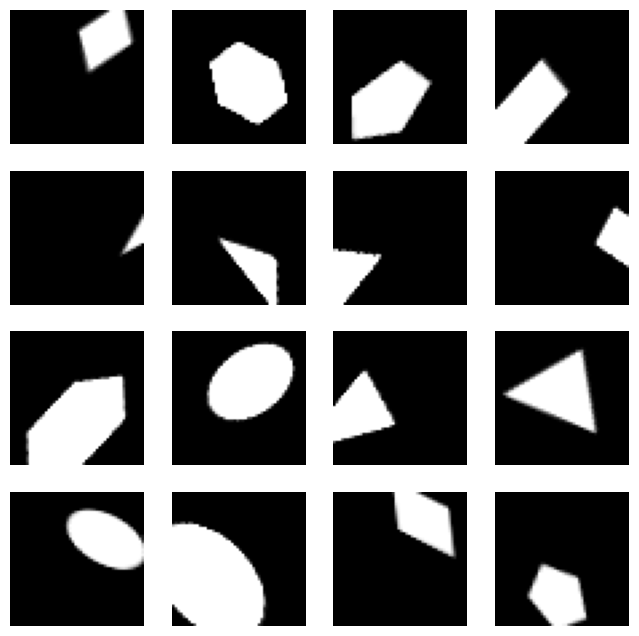

In [6]:
#Data augmentation visualisation

data_generator = ImageDataGenerator(
    rotation_range = 90,
    zoom_range = 0.2,
    shear_range = 45,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    channel_shift_range = 0.9,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

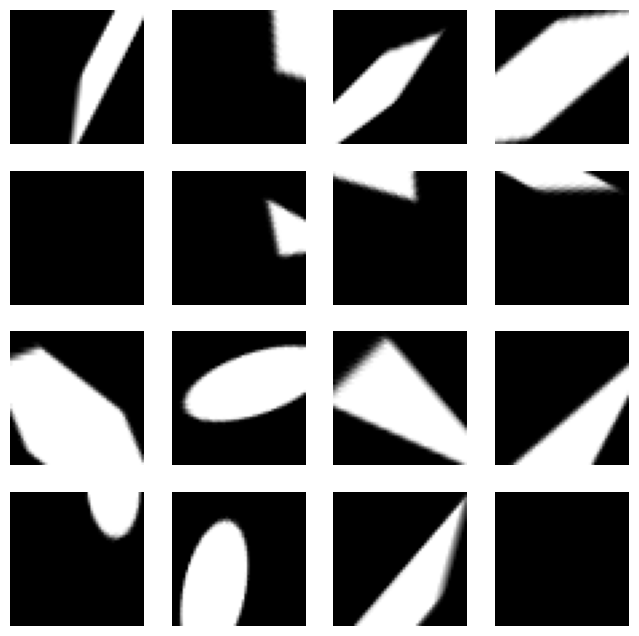

In [7]:
#Train for the worst

data_generator = ImageDataGenerator(
    rotation_range = 180,
    zoom_range = 0.5,
    shear_range = 70,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.25,
    width_shift_range = 0.25,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

In [8]:
#99.48% on advanced model

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(128, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = '99.48_model_17.6MB.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 200, callbacks = [checkpoint]);

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856 

80/80 [==============================] - 4s 52ms/step - loss: 0.5694 - accuracy: 0.7985 - val_loss: 0.4526 - val_accuracy: 0.8330
Epoch 93/200
80/80 [==============================] - 4s 50ms/step - loss: 0.5763 - accuracy: 0.7958 - val_loss: 0.4363 - val_accuracy: 0.8410
Epoch 94/200
80/80 [==============================] - 4s 50ms/step - loss: 0.5451 - accuracy: 0.8071 - val_loss: 0.4602 - val_accuracy: 0.8470
Epoch 95/200
80/80 [==============================] - 4s 50ms/step - loss: 0.5660 - accuracy: 0.7990 - val_loss: 0.4408 - val_accuracy: 0.8350
Epoch 96/200
80/80 [==============================] - 4s 51ms/step - loss: 0.5497 - accuracy: 0.8061 - val_loss: 0.4688 - val_accuracy: 0.8300
Epoch 97/200
80/80 [==============================] - 4s 51ms/step - loss: 0.5534 - accuracy: 0.8008 - val_loss: 0.4841 - val_accuracy: 0.8285
Epoch 98/200
80/80 [==============================] - 4s 51ms/step - loss: 0.5556 - accuracy: 0.8094 - val_loss: 0.4362 - val_accuracy: 0.8475
Epoch 99/200

80/80 [==============================] - 4s 51ms/step - loss: 0.4953 - accuracy: 0.8259 - val_loss: 0.3995 - val_accuracy: 0.8590
Epoch 150/200
80/80 [==============================] - 4s 51ms/step - loss: 0.5152 - accuracy: 0.8171 - val_loss: 0.4047 - val_accuracy: 0.8550
Epoch 151/200
80/80 [==============================] - 4s 51ms/step - loss: 0.4942 - accuracy: 0.8243 - val_loss: 0.3920 - val_accuracy: 0.8615
Epoch 152/200
80/80 [==============================] - 4s 50ms/step - loss: 0.4890 - accuracy: 0.8305 - val_loss: 0.3925 - val_accuracy: 0.8540
Epoch 153/200
80/80 [==============================] - 4s 50ms/step - loss: 0.5265 - accuracy: 0.8180 - val_loss: 0.4401 - val_accuracy: 0.8485
Epoch 154/200
80/80 [==============================] - 4s 51ms/step - loss: 0.4975 - accuracy: 0.8271 - val_loss: 0.4122 - val_accuracy: 0.8415
Epoch 155/200
80/80 [==============================] - 4s 51ms/step - loss: 0.5029 - accuracy: 0.8288 - val_loss: 0.4379 - val_accuracy: 0.8335
Epoch 

<AxesSubplot: >

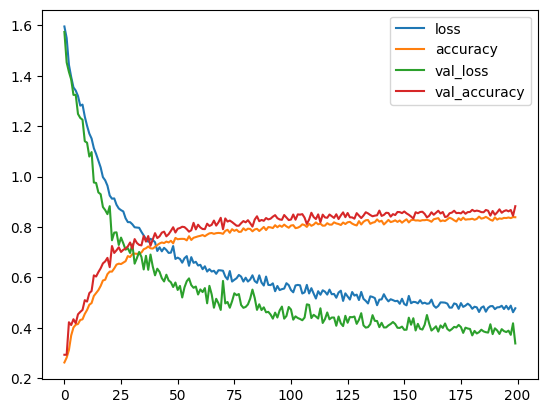

In [9]:
#Funny squiggles

pd.DataFrame(hist.history).plot()

In [10]:
#Fail

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = 'failed_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 200, callbacks = [checkpoint]);

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       7385

Epoch 28/200
80/80 [==============================] - 4s 51ms/step - loss: 0.7982 - accuracy: 0.6895 - val_loss: 0.9482 - val_accuracy: 0.6380
Epoch 29/200
80/80 [==============================] - 4s 51ms/step - loss: 0.7516 - accuracy: 0.7089 - val_loss: 0.8146 - val_accuracy: 0.6780
Epoch 30/200
80/80 [==============================] - 4s 53ms/step - loss: 0.7682 - accuracy: 0.7115 - val_loss: 0.6705 - val_accuracy: 0.7350
Epoch 31/200
80/80 [==============================] - 4s 50ms/step - loss: 0.7711 - accuracy: 0.7048 - val_loss: 0.7948 - val_accuracy: 0.6940
Epoch 32/200
80/80 [==============================] - 4s 52ms/step - loss: 0.7550 - accuracy: 0.7163 - val_loss: 0.8170 - val_accuracy: 0.6900
Epoch 33/200
80/80 [==============================] - 4s 51ms/step - loss: 0.7366 - accuracy: 0.7238 - val_loss: 0.8100 - val_accuracy: 0.6900
Epoch 34/200
80/80 [==============================] - 4s 50ms/step - loss: 0.7227 - accuracy: 0.7226 - val_loss: 0.8378 - val_accuracy: 0.6680

80/80 [==============================] - 4s 51ms/step - loss: 0.4553 - accuracy: 0.8429 - val_loss: 0.4441 - val_accuracy: 0.8495
Epoch 143/200
80/80 [==============================] - 4s 51ms/step - loss: 0.4545 - accuracy: 0.8476 - val_loss: 0.4129 - val_accuracy: 0.8745
Epoch 144/200
80/80 [==============================] - 4s 52ms/step - loss: 0.4321 - accuracy: 0.8575 - val_loss: 0.3857 - val_accuracy: 0.8745
Epoch 145/200
80/80 [==============================] - 4s 52ms/step - loss: 0.4274 - accuracy: 0.8575 - val_loss: 0.4783 - val_accuracy: 0.8460
Epoch 146/200
80/80 [==============================] - 4s 51ms/step - loss: 0.4356 - accuracy: 0.8523 - val_loss: 0.4168 - val_accuracy: 0.8775
Epoch 147/200
80/80 [==============================] - 4s 53ms/step - loss: 0.4404 - accuracy: 0.8503 - val_loss: 0.3708 - val_accuracy: 0.8865
Epoch 148/200
80/80 [==============================] - 4s 51ms/step - loss: 0.4335 - accuracy: 0.8505 - val_loss: 0.4239 - val_accuracy: 0.8610
Epoch 

Epoch 199/200
80/80 [==============================] - 4s 52ms/step - loss: 0.4055 - accuracy: 0.8741 - val_loss: 0.4015 - val_accuracy: 0.9030
Epoch 200/200
80/80 [==============================] - 4s 52ms/step - loss: 0.4095 - accuracy: 0.8708 - val_loss: 0.3822 - val_accuracy: 0.8930


<AxesSubplot: >

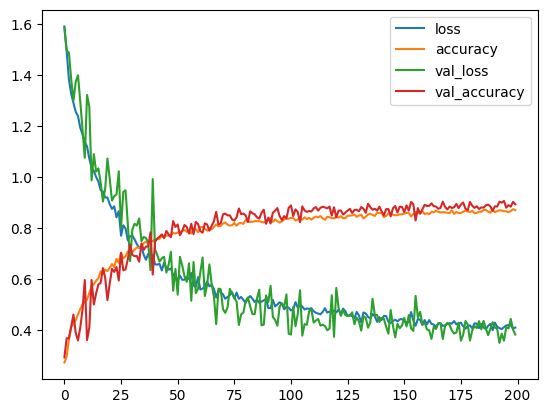

In [11]:
#More funny squiggles

pd.DataFrame(hist.history).plot()

In [ ]:
#Model that got 100% on advanced, 23MB

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(32, kernel_size=(5, 5), padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(4, 4), padding = 'same')(out);
out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(3):
    out = keras.layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(3):
    out = keras.layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(1000, activation = 'relu')(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = '100_model_23MB.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 200, callbacks = [checkpoint]);

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 32)        832       
                                                                 
 activation (Activation)     (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 25, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 25, 25, 64)        0         
                                                           

80/80 [==============================] - 4s 51ms/step - loss: 0.3197 - accuracy: 0.8925 - val_loss: 0.2911 - val_accuracy: 0.9010
Epoch 87/200
80/80 [==============================] - 4s 51ms/step - loss: 0.3012 - accuracy: 0.8975 - val_loss: 0.3003 - val_accuracy: 0.9030
Epoch 88/200
80/80 [==============================] - 4s 51ms/step - loss: 0.3015 - accuracy: 0.8989 - val_loss: 0.2621 - val_accuracy: 0.9145
Epoch 89/200
80/80 [==============================] - 4s 51ms/step - loss: 0.3149 - accuracy: 0.8955 - val_loss: 0.2746 - val_accuracy: 0.9035
Epoch 90/200
80/80 [==============================] - 4s 53ms/step - loss: 0.3042 - accuracy: 0.8994 - val_loss: 0.2553 - val_accuracy: 0.9170
Epoch 91/200
80/80 [==============================] - 4s 52ms/step - loss: 0.3118 - accuracy: 0.8958 - val_loss: 0.3082 - val_accuracy: 0.9000
Epoch 92/200
80/80 [==============================] - 4s 51ms/step - loss: 0.3150 - accuracy: 0.8934 - val_loss: 0.2590 - val_accuracy: 0.9150
Epoch 93/200

80/80 [==============================] - 4s 51ms/step - loss: 0.2798 - accuracy: 0.9106 - val_loss: 0.2501 - val_accuracy: 0.9175
Epoch 144/200
80/80 [==============================] - 4s 51ms/step - loss: 0.2801 - accuracy: 0.9101 - val_loss: 0.2522 - val_accuracy: 0.9195
Epoch 145/200
80/80 [==============================] - 4s 53ms/step - loss: 0.2809 - accuracy: 0.9041 - val_loss: 0.2450 - val_accuracy: 0.9165
Epoch 146/200
80/80 [==============================] - 4s 52ms/step - loss: 0.2742 - accuracy: 0.9130 - val_loss: 0.2408 - val_accuracy: 0.9280
Epoch 147/200
80/80 [==============================] - 4s 52ms/step - loss: 0.2740 - accuracy: 0.9100 - val_loss: 0.2536 - val_accuracy: 0.9220
Epoch 148/200
80/80 [==============================] - 4s 51ms/step - loss: 0.2949 - accuracy: 0.9041 - val_loss: 0.2494 - val_accuracy: 0.9155
Epoch 149/200
80/80 [==============================] - 4s 52ms/step - loss: 0.2706 - accuracy: 0.9141 - val_loss: 0.2496 - val_accuracy: 0.9170
Epoch 

In [ ]:
#Even more funny squiggles

pd.DataFrame(hist.history).plot()

In [ ]:
#Load the winner, continue training and save all epochs for... reasons

model = tf.keras.models.load_model('100_model_23MB.h5');
checkpoint = keras.callbacks.ModelCheckpoint(filepath = '23MB_epochs\{epoch:d}model.h5', monitor = 'val_loss', save_best_only = False, mode = 'min');
hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 20, callbacks = [checkpoint]);

In [ ]:
#Here's a little lesson in trickery

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

@background
def brute_force(x):
    url = 'https://us-central1-aiprimer.cloudfunctions.net/flatland?model_link=https://github.com/DDomjosa/flatland/blob/main/23MB_epochs/'+str(x)+'model.h5?raw=true';
    uf = urllib.request.urlopen(url)
    html = uf.read()
    print('Epoch = ' + str(x) + ':\n\n' + html.decode("utf-8") + '\n')
    
for i in range(1, 21):
    brute_force(i)

In [ ]:
#100% on advanced, 673KB
#Needs A LOT of training to reach 100%

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(16, kernel_size=(5, 5), activation = 'relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Conv2D(16, kernel_size=(5, 5), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(5, 5), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = '100_model_673KB.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 2500, callbacks = [checkpoint]);

In [ ]:
#The funniest of squiggles

pd.DataFrame(hist.history).plot()

In [ ]:
model = tf.keras.models.load_model('100_model_673KB.h5');
checkpoint = keras.callbacks.ModelCheckpoint(filepath = '673KB_epochs\{epoch:d}model.h5', monitor = 'val_loss', save_best_only = False, mode = 'min');
hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 20, callbacks = [checkpoint]);

In [ ]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

@background
def brute_force(x):
    url = 'https://us-central1-aiprimer.cloudfunctions.net/flatland?model_link=https://github.com/DDomjosa/flatland/blob/main/673KB_epochs/'+str(x)+'model.h5?raw=true';
    uf = urllib.request.urlopen(url)
    html = uf.read()
    print('Epoch = ' + str(x) + ':\n\n' + html.decode("utf-8") + '\n')
    
for i in range(1, 21):
    brute_force(i)

In [17]:
inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(8, kernel_size=(3, 3), activation = 'relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Conv2D(8, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(8, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(32, kernel_size=(2, 2), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(2, 2), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 500, callbacks = [checkpoint]);

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_81 (Conv2D)          (None, 50, 50, 8)         80        
                                                                 
 conv2d_82 (Conv2D)          (None, 50, 50, 8)         584       
                                                                 
 conv2d_83 (Conv2D)          (None, 50, 50, 8)         584       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 25, 25, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 25, 25, 16)        1168      
                                                           

Epoch 37/500
80/80 [==============================] - 4s 51ms/step - loss: 0.8941 - accuracy: 0.6598 - val_loss: 0.8653 - val_accuracy: 0.6810
Epoch 38/500
80/80 [==============================] - 4s 51ms/step - loss: 0.9147 - accuracy: 0.6388 - val_loss: 0.8614 - val_accuracy: 0.6725
Epoch 39/500
80/80 [==============================] - 4s 51ms/step - loss: 0.9060 - accuracy: 0.6504 - val_loss: 0.8222 - val_accuracy: 0.6930
Epoch 40/500
80/80 [==============================] - 4s 49ms/step - loss: 0.8992 - accuracy: 0.6589 - val_loss: 0.8237 - val_accuracy: 0.6945
Epoch 41/500
80/80 [==============================] - 4s 50ms/step - loss: 0.8769 - accuracy: 0.6624 - val_loss: 0.8275 - val_accuracy: 0.6995
Epoch 42/500
80/80 [==============================] - 4s 51ms/step - loss: 0.8854 - accuracy: 0.6660 - val_loss: 0.8317 - val_accuracy: 0.6855
Epoch 43/500
80/80 [==============================] - 4s 50ms/step - loss: 0.8945 - accuracy: 0.6495 - val_loss: 0.8292 - val_accuracy: 0.6795

80/80 [==============================] - 4s 51ms/step - loss: 0.7178 - accuracy: 0.7388 - val_loss: 0.6372 - val_accuracy: 0.7765
Epoch 95/500
80/80 [==============================] - 4s 50ms/step - loss: 0.7138 - accuracy: 0.7399 - val_loss: 0.6861 - val_accuracy: 0.7490
Epoch 96/500
80/80 [==============================] - 4s 50ms/step - loss: 0.7130 - accuracy: 0.7441 - val_loss: 0.7501 - val_accuracy: 0.7100
Epoch 97/500
80/80 [==============================] - 4s 50ms/step - loss: 0.7263 - accuracy: 0.7290 - val_loss: 0.6773 - val_accuracy: 0.7515
Epoch 98/500
80/80 [==============================] - 4s 52ms/step - loss: 0.7095 - accuracy: 0.7428 - val_loss: 0.6349 - val_accuracy: 0.7605
Epoch 99/500
80/80 [==============================] - 4s 49ms/step - loss: 0.7388 - accuracy: 0.7280 - val_loss: 0.6562 - val_accuracy: 0.7630
Epoch 100/500
80/80 [==============================] - 4s 50ms/step - loss: 0.7246 - accuracy: 0.7324 - val_loss: 0.6962 - val_accuracy: 0.7560
Epoch 101/5

80/80 [==============================] - 4s 50ms/step - loss: 0.6539 - accuracy: 0.7603 - val_loss: 0.6121 - val_accuracy: 0.7760
Epoch 152/500
80/80 [==============================] - 4s 51ms/step - loss: 0.6629 - accuracy: 0.7574 - val_loss: 0.5857 - val_accuracy: 0.7950
Epoch 153/500
80/80 [==============================] - 4s 50ms/step - loss: 0.6574 - accuracy: 0.7638 - val_loss: 0.5741 - val_accuracy: 0.7865
Epoch 154/500
80/80 [==============================] - 4s 51ms/step - loss: 0.6274 - accuracy: 0.7713 - val_loss: 0.5823 - val_accuracy: 0.7915
Epoch 155/500
80/80 [==============================] - 4s 51ms/step - loss: 0.6337 - accuracy: 0.7688 - val_loss: 0.5922 - val_accuracy: 0.7785
Epoch 156/500
80/80 [==============================] - 4s 49ms/step - loss: 0.6428 - accuracy: 0.7685 - val_loss: 0.5801 - val_accuracy: 0.7925
Epoch 157/500
80/80 [==============================] - 4s 50ms/step - loss: 0.6445 - accuracy: 0.7678 - val_loss: 0.5874 - val_accuracy: 0.7905
Epoch 

Epoch 208/500
80/80 [==============================] - 4s 51ms/step - loss: 0.5874 - accuracy: 0.7910 - val_loss: 0.4950 - val_accuracy: 0.8230
Epoch 209/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5897 - accuracy: 0.7885 - val_loss: 0.5091 - val_accuracy: 0.8210
Epoch 210/500
80/80 [==============================] - 4s 51ms/step - loss: 0.5911 - accuracy: 0.7843 - val_loss: 0.5887 - val_accuracy: 0.7815
Epoch 211/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5972 - accuracy: 0.7900 - val_loss: 0.5498 - val_accuracy: 0.8115
Epoch 212/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5847 - accuracy: 0.7931 - val_loss: 0.5434 - val_accuracy: 0.8220
Epoch 213/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5749 - accuracy: 0.7950 - val_loss: 0.5041 - val_accuracy: 0.8200
Epoch 214/500
80/80 [==============================] - 4s 51ms/step - loss: 0.5930 - accuracy: 0.7864 - val_loss: 0.5139 - val_accuracy:

Epoch 265/500
80/80 [==============================] - 4s 51ms/step - loss: 0.5591 - accuracy: 0.8001 - val_loss: 0.4880 - val_accuracy: 0.8355
Epoch 266/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5594 - accuracy: 0.8033 - val_loss: 0.5289 - val_accuracy: 0.8130
Epoch 267/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5393 - accuracy: 0.8083 - val_loss: 0.4821 - val_accuracy: 0.8315
Epoch 268/500
80/80 [==============================] - 4s 51ms/step - loss: 0.5465 - accuracy: 0.8039 - val_loss: 0.5082 - val_accuracy: 0.8185
Epoch 269/500
80/80 [==============================] - 4s 53ms/step - loss: 0.5524 - accuracy: 0.8033 - val_loss: 0.4643 - val_accuracy: 0.8375
Epoch 270/500
80/80 [==============================] - 4s 51ms/step - loss: 0.5488 - accuracy: 0.8084 - val_loss: 0.4872 - val_accuracy: 0.8285
Epoch 271/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5427 - accuracy: 0.8069 - val_loss: 0.5328 - val_accuracy:

Epoch 322/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5207 - accuracy: 0.8163 - val_loss: 0.4484 - val_accuracy: 0.8390
Epoch 323/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5278 - accuracy: 0.8100 - val_loss: 0.4640 - val_accuracy: 0.8305
Epoch 324/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5296 - accuracy: 0.8120 - val_loss: 0.4700 - val_accuracy: 0.8340
Epoch 325/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5263 - accuracy: 0.8231 - val_loss: 0.4672 - val_accuracy: 0.8360
Epoch 326/500
80/80 [==============================] - 4s 51ms/step - loss: 0.5212 - accuracy: 0.8193 - val_loss: 0.4963 - val_accuracy: 0.8210
Epoch 327/500
80/80 [==============================] - 4s 50ms/step - loss: 0.5258 - accuracy: 0.8178 - val_loss: 0.4834 - val_accuracy: 0.8210
Epoch 328/500
80/80 [==============================] - 4s 49ms/step - loss: 0.5367 - accuracy: 0.8085 - val_loss: 0.5139 - val_accuracy:

Epoch 379/500
80/80 [==============================] - 4s 51ms/step - loss: 0.4967 - accuracy: 0.8268 - val_loss: 0.4148 - val_accuracy: 0.8605
Epoch 380/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4868 - accuracy: 0.8319 - val_loss: 0.4633 - val_accuracy: 0.8270
Epoch 381/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4951 - accuracy: 0.8348 - val_loss: 0.4292 - val_accuracy: 0.8555
Epoch 382/500
80/80 [==============================] - 4s 51ms/step - loss: 0.5165 - accuracy: 0.8158 - val_loss: 0.4262 - val_accuracy: 0.8570
Epoch 383/500
80/80 [==============================] - 4s 51ms/step - loss: 0.4900 - accuracy: 0.8315 - val_loss: 0.4753 - val_accuracy: 0.8260
Epoch 384/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4993 - accuracy: 0.8269 - val_loss: 0.4461 - val_accuracy: 0.8430
Epoch 385/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4965 - accuracy: 0.8236 - val_loss: 0.4923 - val_accuracy:

Epoch 436/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4889 - accuracy: 0.8295 - val_loss: 0.4165 - val_accuracy: 0.8485
Epoch 437/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4762 - accuracy: 0.8373 - val_loss: 0.4654 - val_accuracy: 0.8285
Epoch 438/500
80/80 [==============================] - 4s 51ms/step - loss: 0.4757 - accuracy: 0.8370 - val_loss: 0.4151 - val_accuracy: 0.8555
Epoch 439/500
80/80 [==============================] - 4s 51ms/step - loss: 0.4768 - accuracy: 0.8365 - val_loss: 0.4068 - val_accuracy: 0.8625
Epoch 440/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4714 - accuracy: 0.8396 - val_loss: 0.4141 - val_accuracy: 0.8615
Epoch 441/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4762 - accuracy: 0.8371 - val_loss: 0.4490 - val_accuracy: 0.8485
Epoch 442/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4657 - accuracy: 0.8369 - val_loss: 0.4677 - val_accuracy:

Epoch 493/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4703 - accuracy: 0.8343 - val_loss: 0.4333 - val_accuracy: 0.8530
Epoch 494/500
80/80 [==============================] - 4s 51ms/step - loss: 0.4659 - accuracy: 0.8418 - val_loss: 0.4010 - val_accuracy: 0.8570
Epoch 495/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4611 - accuracy: 0.8373 - val_loss: 0.4120 - val_accuracy: 0.8575
Epoch 496/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4697 - accuracy: 0.8353 - val_loss: 0.4217 - val_accuracy: 0.8530
Epoch 497/500
80/80 [==============================] - 4s 50ms/step - loss: 0.4445 - accuracy: 0.8449 - val_loss: 0.3923 - val_accuracy: 0.8720
Epoch 498/500
80/80 [==============================] - 4s 51ms/step - loss: 0.4398 - accuracy: 0.8538 - val_loss: 0.3972 - val_accuracy: 0.8650
Epoch 499/500
80/80 [==============================] - 4s 51ms/step - loss: 0.4613 - accuracy: 0.8446 - val_loss: 0.4173 - val_accuracy:

In [ ]:
hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 2000, callbacks = [checkpoint]);

Epoch 1/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4640 - accuracy: 0.8416 - val_loss: 0.4163 - val_accuracy: 0.8565
Epoch 2/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4568 - accuracy: 0.8466 - val_loss: 0.3848 - val_accuracy: 0.8700
Epoch 3/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4451 - accuracy: 0.8466 - val_loss: 0.3933 - val_accuracy: 0.8600
Epoch 4/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4468 - accuracy: 0.8473 - val_loss: 0.4145 - val_accuracy: 0.8595
Epoch 5/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4663 - accuracy: 0.8391 - val_loss: 0.4158 - val_accuracy: 0.8660
Epoch 6/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4664 - accuracy: 0.8409 - val_loss: 0.3886 - val_accuracy: 0.8725
Epoch 7/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4449 - accuracy: 0.8444 - val_loss: 0.4156 - val_accuracy: 0.8580

Epoch 58/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.4442 - accuracy: 0.8490 - val_loss: 0.4025 - val_accuracy: 0.8575
Epoch 59/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4515 - accuracy: 0.8495 - val_loss: 0.4057 - val_accuracy: 0.8670
Epoch 60/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4445 - accuracy: 0.8525 - val_loss: 0.3622 - val_accuracy: 0.8745
Epoch 61/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.4393 - accuracy: 0.8534 - val_loss: 0.3781 - val_accuracy: 0.8745
Epoch 62/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.4453 - accuracy: 0.8503 - val_loss: 0.3898 - val_accuracy: 0.8560
Epoch 63/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4406 - accuracy: 0.8515 - val_loss: 0.4068 - val_accuracy: 0.8525
Epoch 64/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4439 - accuracy: 0.8465 - val_loss: 0.3895 - val_accuracy:

Epoch 115/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4426 - accuracy: 0.8544 - val_loss: 0.4057 - val_accuracy: 0.8565
Epoch 116/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4369 - accuracy: 0.8513 - val_loss: 0.3811 - val_accuracy: 0.8610
Epoch 117/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4511 - accuracy: 0.8508 - val_loss: 0.3653 - val_accuracy: 0.8735
Epoch 118/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4427 - accuracy: 0.8566 - val_loss: 0.3868 - val_accuracy: 0.8605
Epoch 119/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4247 - accuracy: 0.8589 - val_loss: 0.3682 - val_accuracy: 0.8780
Epoch 120/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4454 - accuracy: 0.8476 - val_loss: 0.3951 - val_accuracy: 0.8640
Epoch 121/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4376 - accuracy: 0.8574 - val_loss: 0.3856 - val_ac

80/80 [==============================] - 4s 52ms/step - loss: 0.4454 - accuracy: 0.8531 - val_loss: 0.3467 - val_accuracy: 0.8830
Epoch 172/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4212 - accuracy: 0.8628 - val_loss: 0.3838 - val_accuracy: 0.8680
Epoch 173/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4281 - accuracy: 0.8565 - val_loss: 0.3694 - val_accuracy: 0.8695
Epoch 174/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4297 - accuracy: 0.8546 - val_loss: 0.3673 - val_accuracy: 0.8685
Epoch 175/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4235 - accuracy: 0.8600 - val_loss: 0.3900 - val_accuracy: 0.8645
Epoch 176/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4126 - accuracy: 0.8599 - val_loss: 0.3821 - val_accuracy: 0.8690
Epoch 177/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4100 - accuracy: 0.8640 - val_loss: 0.3530 - val_accuracy: 0.8935


80/80 [==============================] - 4s 52ms/step - loss: 0.4140 - accuracy: 0.8579 - val_loss: 0.3931 - val_accuracy: 0.8585
Epoch 228/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4125 - accuracy: 0.8625 - val_loss: 0.3558 - val_accuracy: 0.8755
Epoch 229/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4252 - accuracy: 0.8594 - val_loss: 0.3717 - val_accuracy: 0.8630
Epoch 230/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4183 - accuracy: 0.8581 - val_loss: 0.3667 - val_accuracy: 0.8815
Epoch 231/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4173 - accuracy: 0.8598 - val_loss: 0.3923 - val_accuracy: 0.8690
Epoch 232/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.4069 - accuracy: 0.8630 - val_loss: 0.3667 - val_accuracy: 0.8775
Epoch 233/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4196 - accuracy: 0.8615 - val_loss: 0.3473 - val_accuracy: 0.8810


80/80 [==============================] - 4s 51ms/step - loss: 0.4082 - accuracy: 0.8665 - val_loss: 0.3711 - val_accuracy: 0.8650
Epoch 284/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3948 - accuracy: 0.8696 - val_loss: 0.4051 - val_accuracy: 0.8625
Epoch 285/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3984 - accuracy: 0.8688 - val_loss: 0.3797 - val_accuracy: 0.8690
Epoch 286/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3924 - accuracy: 0.8724 - val_loss: 0.3349 - val_accuracy: 0.8860
Epoch 287/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4097 - accuracy: 0.8651 - val_loss: 0.3402 - val_accuracy: 0.8810
Epoch 288/2000
80/80 [==============================] - 4s 55ms/step - loss: 0.3950 - accuracy: 0.8651 - val_loss: 0.3455 - val_accuracy: 0.8915
Epoch 289/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3850 - accuracy: 0.8731 - val_loss: 0.3441 - val_accuracy: 0.8840


80/80 [==============================] - 4s 51ms/step - loss: 0.3928 - accuracy: 0.8713 - val_loss: 0.3558 - val_accuracy: 0.8770
Epoch 340/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3934 - accuracy: 0.8695 - val_loss: 0.3284 - val_accuracy: 0.8910
Epoch 341/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3973 - accuracy: 0.8695 - val_loss: 0.3492 - val_accuracy: 0.8855
Epoch 342/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3856 - accuracy: 0.8714 - val_loss: 0.3723 - val_accuracy: 0.8675
Epoch 343/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.4109 - accuracy: 0.8609 - val_loss: 0.3523 - val_accuracy: 0.8775
Epoch 344/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3913 - accuracy: 0.8695 - val_loss: 0.3395 - val_accuracy: 0.8940
Epoch 345/2000
80/80 [==============================] - 4s 53ms/step - loss: 0.3787 - accuracy: 0.8780 - val_loss: 0.3079 - val_accuracy: 0.8955


80/80 [==============================] - 4s 51ms/step - loss: 0.3785 - accuracy: 0.8754 - val_loss: 0.3304 - val_accuracy: 0.8930
Epoch 396/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3975 - accuracy: 0.8673 - val_loss: 0.3371 - val_accuracy: 0.8820
Epoch 397/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3901 - accuracy: 0.8731 - val_loss: 0.3509 - val_accuracy: 0.8810
Epoch 398/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3964 - accuracy: 0.8714 - val_loss: 0.3430 - val_accuracy: 0.8810
Epoch 399/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3905 - accuracy: 0.8698 - val_loss: 0.3608 - val_accuracy: 0.8740
Epoch 400/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.4079 - accuracy: 0.8661 - val_loss: 0.3470 - val_accuracy: 0.8875
Epoch 401/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3836 - accuracy: 0.8733 - val_loss: 0.3484 - val_accuracy: 0.8930


80/80 [==============================] - 4s 52ms/step - loss: 0.3881 - accuracy: 0.8718 - val_loss: 0.3051 - val_accuracy: 0.8950
Epoch 452/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3867 - accuracy: 0.8760 - val_loss: 0.3283 - val_accuracy: 0.8900
Epoch 453/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3831 - accuracy: 0.8750 - val_loss: 0.3400 - val_accuracy: 0.8880
Epoch 454/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3822 - accuracy: 0.8745 - val_loss: 0.3257 - val_accuracy: 0.8880
Epoch 455/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3860 - accuracy: 0.8725 - val_loss: 0.3308 - val_accuracy: 0.8940
Epoch 456/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3885 - accuracy: 0.8720 - val_loss: 0.3345 - val_accuracy: 0.8930
Epoch 457/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3743 - accuracy: 0.8763 - val_loss: 0.3280 - val_accuracy: 0.8890


80/80 [==============================] - 4s 51ms/step - loss: 0.3745 - accuracy: 0.8764 - val_loss: 0.3525 - val_accuracy: 0.8805
Epoch 508/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3724 - accuracy: 0.8801 - val_loss: 0.3372 - val_accuracy: 0.8960
Epoch 509/2000
80/80 [==============================] - 4s 53ms/step - loss: 0.3764 - accuracy: 0.8794 - val_loss: 0.3312 - val_accuracy: 0.8910
Epoch 510/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3737 - accuracy: 0.8745 - val_loss: 0.3076 - val_accuracy: 0.8975
Epoch 511/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3767 - accuracy: 0.8785 - val_loss: 0.3202 - val_accuracy: 0.8890
Epoch 512/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3794 - accuracy: 0.8785 - val_loss: 0.3409 - val_accuracy: 0.8785
Epoch 513/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3738 - accuracy: 0.8768 - val_loss: 0.3257 - val_accuracy: 0.8930


80/80 [==============================] - 4s 50ms/step - loss: 0.3782 - accuracy: 0.8778 - val_loss: 0.3669 - val_accuracy: 0.8670
Epoch 564/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3702 - accuracy: 0.8804 - val_loss: 0.3395 - val_accuracy: 0.8825
Epoch 565/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3753 - accuracy: 0.8801 - val_loss: 0.3109 - val_accuracy: 0.9000
Epoch 566/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3746 - accuracy: 0.8765 - val_loss: 0.3204 - val_accuracy: 0.8940
Epoch 567/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3618 - accuracy: 0.8795 - val_loss: 0.3073 - val_accuracy: 0.8945
Epoch 568/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3639 - accuracy: 0.8780 - val_loss: 0.3274 - val_accuracy: 0.8910
Epoch 569/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3804 - accuracy: 0.8775 - val_loss: 0.3381 - val_accuracy: 0.8920


80/80 [==============================] - 4s 50ms/step - loss: 0.3622 - accuracy: 0.8825 - val_loss: 0.3332 - val_accuracy: 0.8920
Epoch 620/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3654 - accuracy: 0.8789 - val_loss: 0.3120 - val_accuracy: 0.8940
Epoch 621/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3544 - accuracy: 0.8833 - val_loss: 0.3076 - val_accuracy: 0.8995
Epoch 622/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3621 - accuracy: 0.8803 - val_loss: 0.3202 - val_accuracy: 0.9000
Epoch 623/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3706 - accuracy: 0.8805 - val_loss: 0.3267 - val_accuracy: 0.9000
Epoch 624/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3644 - accuracy: 0.8834 - val_loss: 0.3172 - val_accuracy: 0.8985
Epoch 625/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3665 - accuracy: 0.8820 - val_loss: 0.3198 - val_accuracy: 0.9000


80/80 [==============================] - 4s 50ms/step - loss: 0.3710 - accuracy: 0.8783 - val_loss: 0.3124 - val_accuracy: 0.8965
Epoch 676/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3764 - accuracy: 0.8744 - val_loss: 0.3184 - val_accuracy: 0.8875
Epoch 677/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3537 - accuracy: 0.8904 - val_loss: 0.3097 - val_accuracy: 0.8985
Epoch 678/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3743 - accuracy: 0.8738 - val_loss: 0.3065 - val_accuracy: 0.8970
Epoch 679/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3516 - accuracy: 0.8874 - val_loss: 0.2992 - val_accuracy: 0.8860
Epoch 680/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3548 - accuracy: 0.8846 - val_loss: 0.3168 - val_accuracy: 0.8925
Epoch 681/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3584 - accuracy: 0.8840 - val_loss: 0.3223 - val_accuracy: 0.8985


80/80 [==============================] - 4s 50ms/step - loss: 0.3560 - accuracy: 0.8826 - val_loss: 0.3120 - val_accuracy: 0.8960
Epoch 732/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3688 - accuracy: 0.8828 - val_loss: 0.2876 - val_accuracy: 0.8995
Epoch 733/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3642 - accuracy: 0.8845 - val_loss: 0.3362 - val_accuracy: 0.8890
Epoch 734/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3710 - accuracy: 0.8828 - val_loss: 0.3055 - val_accuracy: 0.8980
Epoch 735/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3588 - accuracy: 0.8838 - val_loss: 0.3030 - val_accuracy: 0.9025
Epoch 736/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3611 - accuracy: 0.8805 - val_loss: 0.3242 - val_accuracy: 0.8925
Epoch 737/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3635 - accuracy: 0.8850 - val_loss: 0.3140 - val_accuracy: 0.8995


80/80 [==============================] - 4s 51ms/step - loss: 0.3473 - accuracy: 0.8878 - val_loss: 0.2970 - val_accuracy: 0.8950
Epoch 788/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3408 - accuracy: 0.8886 - val_loss: 0.3139 - val_accuracy: 0.8940
Epoch 789/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3530 - accuracy: 0.8865 - val_loss: 0.3071 - val_accuracy: 0.8945
Epoch 790/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3561 - accuracy: 0.8816 - val_loss: 0.3321 - val_accuracy: 0.8865
Epoch 791/2000
80/80 [==============================] - 4s 56ms/step - loss: 0.3561 - accuracy: 0.8834 - val_loss: 0.3034 - val_accuracy: 0.8945
Epoch 792/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3553 - accuracy: 0.8860 - val_loss: 0.3169 - val_accuracy: 0.9020
Epoch 793/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3492 - accuracy: 0.8876 - val_loss: 0.3124 - val_accuracy: 0.8980


80/80 [==============================] - 4s 51ms/step - loss: 0.3607 - accuracy: 0.8828 - val_loss: 0.3172 - val_accuracy: 0.8925
Epoch 844/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3453 - accuracy: 0.8893 - val_loss: 0.3058 - val_accuracy: 0.9020
Epoch 845/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3378 - accuracy: 0.8909 - val_loss: 0.3095 - val_accuracy: 0.8940
Epoch 846/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3656 - accuracy: 0.8783 - val_loss: 0.3034 - val_accuracy: 0.8985
Epoch 847/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3522 - accuracy: 0.8845 - val_loss: 0.3132 - val_accuracy: 0.9010
Epoch 848/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3469 - accuracy: 0.8930 - val_loss: 0.2963 - val_accuracy: 0.9115
Epoch 849/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3342 - accuracy: 0.8926 - val_loss: 0.3214 - val_accuracy: 0.8995


80/80 [==============================] - 4s 50ms/step - loss: 0.3481 - accuracy: 0.8863 - val_loss: 0.3250 - val_accuracy: 0.8840
Epoch 900/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3456 - accuracy: 0.8896 - val_loss: 0.3013 - val_accuracy: 0.8975
Epoch 901/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3557 - accuracy: 0.8850 - val_loss: 0.3136 - val_accuracy: 0.8965
Epoch 902/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3579 - accuracy: 0.8841 - val_loss: 0.3034 - val_accuracy: 0.8995
Epoch 903/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3480 - accuracy: 0.8876 - val_loss: 0.3039 - val_accuracy: 0.8935
Epoch 904/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3396 - accuracy: 0.8908 - val_loss: 0.3198 - val_accuracy: 0.8950
Epoch 905/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3478 - accuracy: 0.8855 - val_loss: 0.3018 - val_accuracy: 0.9000


80/80 [==============================] - 4s 51ms/step - loss: 0.3497 - accuracy: 0.8865 - val_loss: 0.3037 - val_accuracy: 0.8970
Epoch 956/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3461 - accuracy: 0.8948 - val_loss: 0.3175 - val_accuracy: 0.8910
Epoch 957/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3492 - accuracy: 0.8899 - val_loss: 0.3286 - val_accuracy: 0.8925
Epoch 958/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3396 - accuracy: 0.8939 - val_loss: 0.2943 - val_accuracy: 0.8960
Epoch 959/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3382 - accuracy: 0.8939 - val_loss: 0.3034 - val_accuracy: 0.9060
Epoch 960/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3508 - accuracy: 0.8866 - val_loss: 0.3233 - val_accuracy: 0.8890
Epoch 961/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3526 - accuracy: 0.8825 - val_loss: 0.2751 - val_accuracy: 0.9145


80/80 [==============================] - 4s 51ms/step - loss: 0.3430 - accuracy: 0.8876 - val_loss: 0.2921 - val_accuracy: 0.8990
Epoch 1012/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3421 - accuracy: 0.8886 - val_loss: 0.2947 - val_accuracy: 0.9015
Epoch 1013/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3475 - accuracy: 0.8868 - val_loss: 0.3156 - val_accuracy: 0.8930
Epoch 1014/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3466 - accuracy: 0.8899 - val_loss: 0.2876 - val_accuracy: 0.9055
Epoch 1015/2000
80/80 [==============================] - 4s 49ms/step - loss: 0.3452 - accuracy: 0.8854 - val_loss: 0.3066 - val_accuracy: 0.9030
Epoch 1016/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3432 - accuracy: 0.8921 - val_loss: 0.3122 - val_accuracy: 0.9050
Epoch 1017/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3441 - accuracy: 0.8908 - val_loss: 0.2938 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.3403 - accuracy: 0.8888 - val_loss: 0.2829 - val_accuracy: 0.9065
Epoch 1068/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3341 - accuracy: 0.8924 - val_loss: 0.3090 - val_accuracy: 0.8955
Epoch 1069/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3357 - accuracy: 0.8909 - val_loss: 0.2690 - val_accuracy: 0.9195
Epoch 1070/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3415 - accuracy: 0.8939 - val_loss: 0.2760 - val_accuracy: 0.9080
Epoch 1071/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3417 - accuracy: 0.8884 - val_loss: 0.3065 - val_accuracy: 0.9000
Epoch 1072/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3567 - accuracy: 0.8836 - val_loss: 0.3235 - val_accuracy: 0.8880
Epoch 1073/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3485 - accuracy: 0.8873 - val_loss: 0.3059 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.3423 - accuracy: 0.8894 - val_loss: 0.3046 - val_accuracy: 0.8930
Epoch 1124/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3380 - accuracy: 0.8909 - val_loss: 0.2812 - val_accuracy: 0.9050
Epoch 1125/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3438 - accuracy: 0.8863 - val_loss: 0.3000 - val_accuracy: 0.9015
Epoch 1126/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3330 - accuracy: 0.8913 - val_loss: 0.2976 - val_accuracy: 0.9025
Epoch 1127/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3432 - accuracy: 0.8915 - val_loss: 0.2981 - val_accuracy: 0.9005
Epoch 1128/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3329 - accuracy: 0.8933 - val_loss: 0.2860 - val_accuracy: 0.9095
Epoch 1129/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3340 - accuracy: 0.8911 - val_loss: 0.2751 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.3373 - accuracy: 0.8901 - val_loss: 0.2888 - val_accuracy: 0.9095
Epoch 1180/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3374 - accuracy: 0.8940 - val_loss: 0.2884 - val_accuracy: 0.9075
Epoch 1181/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3406 - accuracy: 0.8914 - val_loss: 0.2902 - val_accuracy: 0.9080
Epoch 1182/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3287 - accuracy: 0.8936 - val_loss: 0.2970 - val_accuracy: 0.9030
Epoch 1183/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3350 - accuracy: 0.8961 - val_loss: 0.3173 - val_accuracy: 0.8900
Epoch 1184/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3377 - accuracy: 0.8950 - val_loss: 0.3014 - val_accuracy: 0.8960
Epoch 1185/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3369 - accuracy: 0.8959 - val_loss: 0.3190 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.3421 - accuracy: 0.8885 - val_loss: 0.2730 - val_accuracy: 0.9140
Epoch 1236/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3309 - accuracy: 0.8910 - val_loss: 0.2867 - val_accuracy: 0.9115
Epoch 1237/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3427 - accuracy: 0.8898 - val_loss: 0.3131 - val_accuracy: 0.8980
Epoch 1238/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3425 - accuracy: 0.8896 - val_loss: 0.3146 - val_accuracy: 0.8910
Epoch 1239/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3412 - accuracy: 0.8870 - val_loss: 0.2754 - val_accuracy: 0.9095
Epoch 1240/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3486 - accuracy: 0.8886 - val_loss: 0.3113 - val_accuracy: 0.8980
Epoch 1241/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3308 - accuracy: 0.8964 - val_loss: 0.2859 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.3398 - accuracy: 0.8915 - val_loss: 0.2762 - val_accuracy: 0.9040
Epoch 1292/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3292 - accuracy: 0.8946 - val_loss: 0.3108 - val_accuracy: 0.8995
Epoch 1293/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3270 - accuracy: 0.8916 - val_loss: 0.3152 - val_accuracy: 0.8935
Epoch 1294/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3290 - accuracy: 0.8968 - val_loss: 0.2904 - val_accuracy: 0.9065
Epoch 1295/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3352 - accuracy: 0.8935 - val_loss: 0.2983 - val_accuracy: 0.8995
Epoch 1296/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3403 - accuracy: 0.8920 - val_loss: 0.2836 - val_accuracy: 0.9090
Epoch 1297/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3365 - accuracy: 0.8928 - val_loss: 0.2822 - val_accuracy: 0

80/80 [==============================] - 4s 52ms/step - loss: 0.3286 - accuracy: 0.8956 - val_loss: 0.2904 - val_accuracy: 0.9075
Epoch 1348/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3417 - accuracy: 0.8958 - val_loss: 0.2782 - val_accuracy: 0.9105
Epoch 1349/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3420 - accuracy: 0.8926 - val_loss: 0.2937 - val_accuracy: 0.8965
Epoch 1350/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3334 - accuracy: 0.8918 - val_loss: 0.2920 - val_accuracy: 0.9055
Epoch 1351/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3297 - accuracy: 0.8900 - val_loss: 0.2957 - val_accuracy: 0.9005
Epoch 1352/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3311 - accuracy: 0.8924 - val_loss: 0.2886 - val_accuracy: 0.9000
Epoch 1353/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3274 - accuracy: 0.8983 - val_loss: 0.2683 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.3323 - accuracy: 0.8945 - val_loss: 0.2894 - val_accuracy: 0.9025
Epoch 1404/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3253 - accuracy: 0.8936 - val_loss: 0.2729 - val_accuracy: 0.9140
Epoch 1405/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3306 - accuracy: 0.8951 - val_loss: 0.2875 - val_accuracy: 0.9065
Epoch 1406/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3262 - accuracy: 0.8978 - val_loss: 0.2817 - val_accuracy: 0.9115
Epoch 1407/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3304 - accuracy: 0.8985 - val_loss: 0.2604 - val_accuracy: 0.9145
Epoch 1408/2000
80/80 [==============================] - 4s 50ms/step - loss: 0.3273 - accuracy: 0.8939 - val_loss: 0.2867 - val_accuracy: 0.9125
Epoch 1409/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3320 - accuracy: 0.8913 - val_loss: 0.2878 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.3127 - accuracy: 0.8998 - val_loss: 0.2694 - val_accuracy: 0.9150
Epoch 1460/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3251 - accuracy: 0.8980 - val_loss: 0.2951 - val_accuracy: 0.9020
Epoch 1461/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3284 - accuracy: 0.8958 - val_loss: 0.2987 - val_accuracy: 0.8970
Epoch 1462/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3289 - accuracy: 0.8984 - val_loss: 0.2695 - val_accuracy: 0.9110
Epoch 1463/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3183 - accuracy: 0.8978 - val_loss: 0.2791 - val_accuracy: 0.9065
Epoch 1464/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3305 - accuracy: 0.8973 - val_loss: 0.2909 - val_accuracy: 0.9025
Epoch 1465/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3304 - accuracy: 0.8929 - val_loss: 0.2669 - val_accuracy: 0

80/80 [==============================] - 4s 52ms/step - loss: 0.3237 - accuracy: 0.8969 - val_loss: 0.2999 - val_accuracy: 0.8970
Epoch 1516/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3219 - accuracy: 0.8995 - val_loss: 0.2899 - val_accuracy: 0.9125
Epoch 1517/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3343 - accuracy: 0.8940 - val_loss: 0.2810 - val_accuracy: 0.9060
Epoch 1518/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3342 - accuracy: 0.8928 - val_loss: 0.2827 - val_accuracy: 0.9100
Epoch 1519/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3288 - accuracy: 0.8964 - val_loss: 0.2687 - val_accuracy: 0.9175
Epoch 1520/2000
80/80 [==============================] - 4s 51ms/step - loss: 0.3219 - accuracy: 0.9004 - val_loss: 0.2864 - val_accuracy: 0.9040
Epoch 1521/2000
80/80 [==============================] - 4s 52ms/step - loss: 0.3361 - accuracy: 0.8905 - val_loss: 0.2869 - val_accuracy: 0